**Logistic regression analysis with different learning rates, regularization types, regularization parameters, batch sizes, and numbers of epochs.**

In [1]:
#import packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import scikitplot as skplt

from pathlib import Path
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

from functions.make_dataset import *
from functions.nn_pytorch import *

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.preprocessing import LabelEncoder

import autograd.numpy as np
from functions.ffnn import *
from functions.activation_funcs import *
from functions.cost_functions import * 

# For saving figures
figpath  = "/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/Figures"
sys.path.append(figpath)

In [2]:
np.random.seed(2018)
seed = 2018

In [3]:
# get data set for own network

path = "/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/weather_classification_data.csv"
data = pd.read_csv(path)

K = 4 # number of classes

# Identify categorical columns
cat_cols = data.select_dtypes(include=["object"]).columns

# Create label encoders for each categorical column
encoders = {col: LabelEncoder() for col in cat_cols}

# Apply encoding
# String to numerical conversion
for col in cat_cols:
    data[col] = encoders[col].fit_transform(data[col]).astype(int)

X = data.drop("Weather Type", axis=1).values
y = data["Weather Type"].values

# Convert to one-hot targets
inputs = X
targets = np.zeros((len(y), K))
for i, t in enumerate(y):
    targets[i, t] = 1

# Split data into training and test data
X_train, X_test, t_train, t_test = train_test_split(inputs, targets, test_size=0.2, random_state=seed)

# Scale data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# get data for PyTorch

path = "/Users/Martine Pedersen/Oppgaver/Project_3_FYSSTK/weather_classification_data.csv"
dataset = WeatherDataset(csv_file=path) # data is scaled

# Split data into training and test data
# Same indices for both splits
n = len(X)
all_indices = np.arange(n)
train_idx, test_idx = train_test_split(all_indices, test_size=0.2, random_state=seed)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

### **Testing different learning rates and regularization parameters**

In [28]:
# set parameters
epochs = 50
M = 64
rho1, rho2 = 0.9, 0.999

netas = 4 #number of different learning rates
etas = np.logspace(-4, -1, netas)

nlambdas = 4 #number of different regularization parameters
lambdas = np.logspace(-6, -3, nlambdas)

**Own NN**

In [29]:
def accuracy(model, X, t):
    """
    Compute accuracy score
    """
    predictions = model._feed_forward(X)
    pred_class = np.argmax(predictions, axis=1)
    true_class = np.argmax(t, axis=1)
    return np.mean(pred_class == true_class)

In [30]:
# vary learning rate (no regularization)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]


# loop through learning rates
for i in range(netas):
    eta = etas[i]

    # Create a new network
    nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der
    )

    # Train model using SGD and ADAM optimizer
    nn.train_SGD(
        X_train,
        t_train,
        epochs=epochs,
        learning_rate=eta,
        batch_size=M,
        optimizer="Adam"
    )

    # evaluate model on training and test data
    acc_train_matrix_no_reg[i] = accuracy(nn, X_train, t_train)
    acc_test_matrix_no_reg[i] = accuracy(nn, X_test, t_test)


In [31]:
# vary regularization parameter and learning rate (L2 regularization)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        # Create a new network
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs = activation_funcs,
            activation_ders = activation_ders,
            cost_fun = cross_entropy,
            cost_der = cross_entropy_der,
            lamb = lmb,
            cost_fun_type = "L2"
        )

        # Train model using SGD and ADAM optimizer
        nn.train_SGD(
            X_train,
            t_train,
            epochs = epochs,
            learning_rate = eta,
            batch_size = M,
            optimizer = "Adam"
        )

        # evaluate model on training and test data
        acc_train_matrix_L2[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L2[i, j]  = accuracy(nn, X_test,  t_test)


In [32]:
# vary regularization parameter and learning rate (L1 regularization)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]

# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        # Create a new network
        nn = NeuralNetwork(
            network_input_size = input_size,
            layer_output_sizes = layer_sizes,
            activation_funcs = activation_funcs,
            activation_ders = activation_ders,
            cost_fun = cross_entropy,
            cost_der = cross_entropy_der,
            lamb = lmb,
            cost_fun_type = "L1"
        )

        # Train model using SGD and ADAM optimizer
        nn.train_SGD(
            X_train,
            t_train,
            epochs = epochs,
            learning_rate = eta,
            batch_size = M,
            optimizer = "Adam"
        )

        # evaluate model on training and test data
        acc_train_matrix_L1[i, j] = accuracy(nn, X_train, t_train)
        acc_test_matrix_L1[i, j]  = accuracy(nn, X_test,  t_test)

C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_14036\1251859708.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


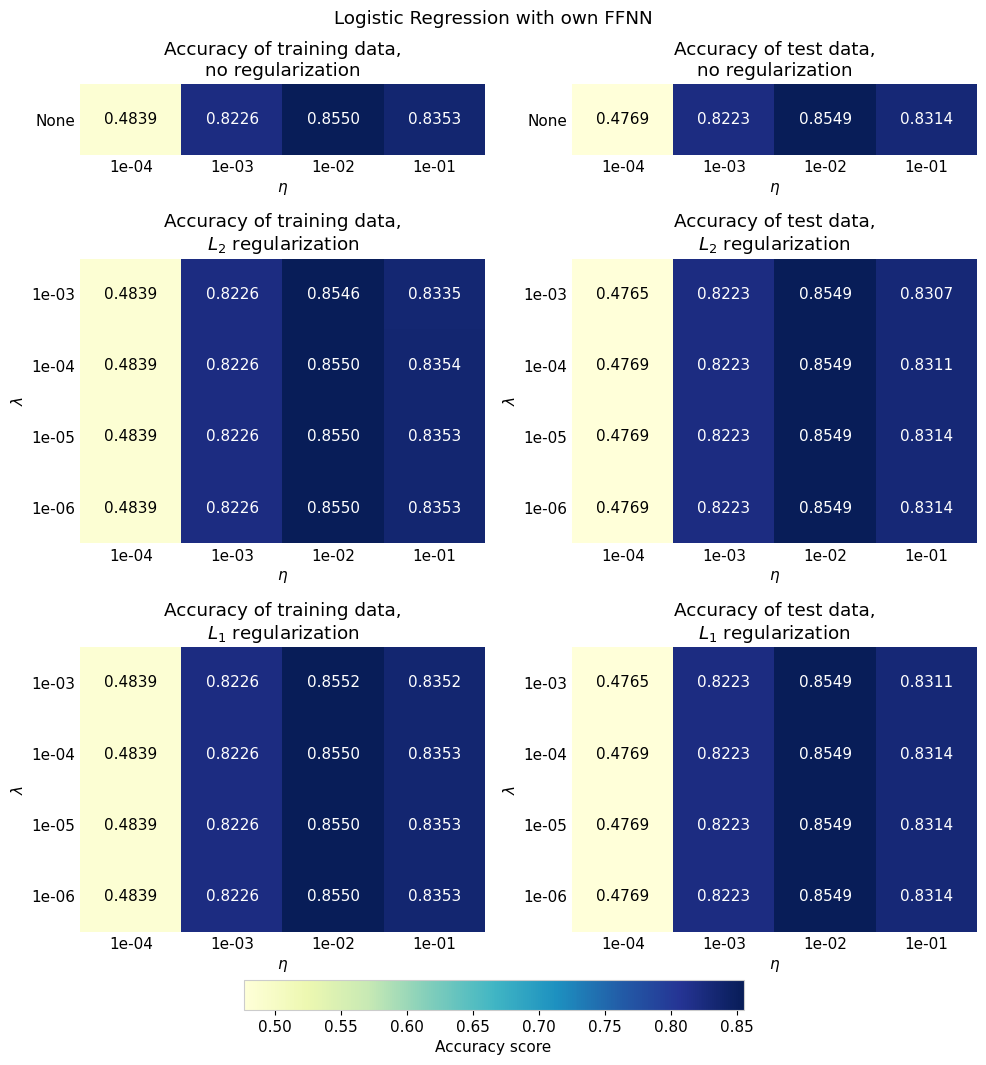

In [33]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect="auto", origin="lower", cmap="YlGnBu", vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(color="none", length=0)

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")
cbar.ax.spines["outline"].set_edgecolor("0.8")

plt.suptitle("Logistic Regression with own FFNN")
fig.tight_layout()
fig.savefig(f"{figpath}/FFNN_Logistic_Regression1.pdf", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# find the optimal model parameters

matrix_list = [acc_test_matrix_no_reg[:,np.newaxis], acc_test_matrix_L2, acc_test_matrix_L1]
reg_types = ["none", "L2", "L1"]

for k in range(3):
    matrix = matrix_list[k]
    reg_type = reg_types[k]
    
    print("Regularization type: " + reg_type)
    
    i, j = np.unravel_index(np.argmax(matrix), matrix.shape) #index of the highest value in the matrix
    value = matrix[i, j] # highest accuracy in the model

    if reg_type == "none":
        best_eta = etas[i] # corresponding eta

        print(fr"Best accuracy = {value:.4f} at learning rate = {best_eta:.0e}.")

    else:
        best_lambda = lambdas[j] # corresponding lambda
        best_eta = etas[i] # corresponding eta
    
        print(fr"Best accuracy = {value:.4f} at λ = {best_lambda:.0e}, learning rate = {best_eta:.0e}.")

Regularization type: none
Best accuracy = 0.8549 at learning rate = 1.0e-02.
Regularization type: L2
Best accuracy = 0.8549 at λ = 1.0e-06, learning rate = 1.0e-02.
Regularization type: L1
Best accuracy = 0.8549 at λ = 1.0e-06, learning rate = 1.0e-02.


In [35]:
# visualize the best model (with the highest accuracy score) based on the test data

# all regularization types performes equally well, so choose to vizualize the results without regularization
eta = best_eta

# Create a new network
nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der
    )

# Train model using SGD and ADAM optimizer
nn.train_SGD(
        X_train,
        t_train,
        epochs=epochs,
        learning_rate=eta,
        batch_size=M,
        optimizer="Adam"
    )

# Make predictions
predictions = nn._feed_forward(X_test)
pred_class = np.argmax(predictions, axis=1)

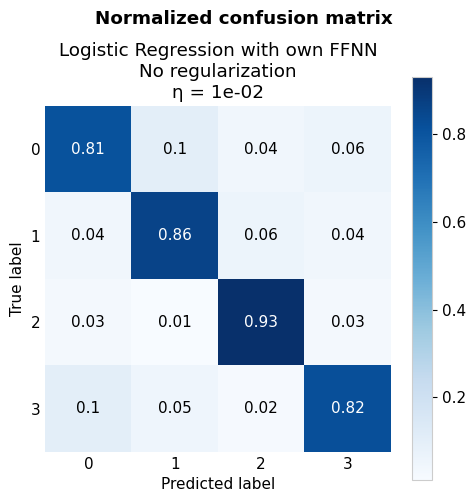

In [36]:
# plot confusion matrix for the best-performing model (for test data)

# convert back from one-hot predictions
t_test_labels = np.argmax(t_test, axis=1)

fig, ax = plt.subplots(figsize=(5,5))
skplt.metrics.plot_confusion_matrix(t_test_labels, pred_class, normalize=True, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(color="none", length=0)
cbar_ax = fig.axes[1]
cbar_ax.spines["outline"].set_edgecolor("0.8")

plt.title(f"Logistic Regression with own FFNN\nNo regularization\nη = {best_eta:.0e}")# \nλ = {best_lmb:.0e}")
plt.suptitle("Normalized confusion matrix", fontweight = "bold")
plt.tight_layout()
fig.savefig(f"{figpath}/FFNN_Logistic_Regression_Confusion_Matrix1.pdf", dpi=200, bbox_inches="tight")
plt.show()

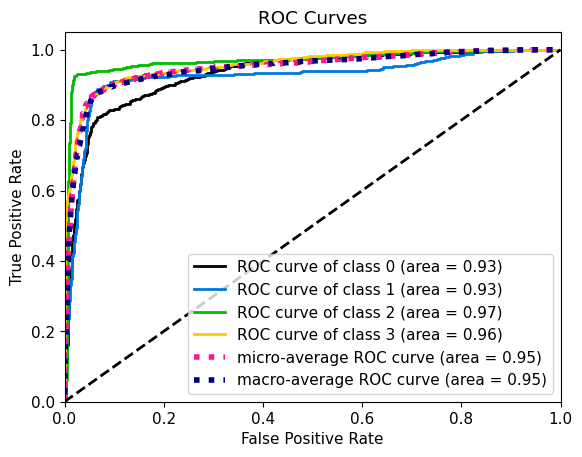

In [37]:
skplt.metrics.plot_roc(t_test_labels, predictions)
plt.show()

**Pytorch**

In [15]:
# vary learning rate (no regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([netas])
acc_test_matrix_no_reg = np.zeros([netas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates
for i in range(netas):
    eta = etas[i]

    np.random.seed(seed)
    torch.manual_seed(seed)
    
    # Create a new network
    model = WeatherNN(input_dim, output_dim)

    # Train model
    model.train_model(train_loader, lr=eta, epochs=epochs)

    # evaluate model on testing and training data
    acc_train_matrix_no_reg[i] = model.evaluate(train_loader)
    acc_test_matrix_no_reg[i]  = model.evaluate(test_loader)


In [16]:
# vary regularization parameter and learning rate (L2 regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_L2 = np.zeros([netas,nlambdas])
acc_test_matrix_L2 = np.zeros([netas,nlambdas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Create new network
        model = WeatherNN(input_dim, output_dim)

        # Train model
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L2")

        # evaluate model on training and test data
        acc_train_matrix_L2[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L2[i, j]  = model.evaluate(test_loader)

In [17]:
# vary regularization parameter and learning rate (L1 regularization)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=M, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=M, shuffle=False)

# matrices for storing accuracy results
acc_train_matrix_L1 = np.zeros([netas,nlambdas])
acc_test_matrix_L1 = np.zeros([netas,nlambdas]) 

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))


# loop through learning rates and regularization parameters
for i in range(netas):
    eta = etas[i]
    for j in range(nlambdas):
        lmb = lambdas[j]

        np.random.seed(seed)
        torch.manual_seed(seed)
        
        # Create new network
        model = WeatherNN(input_dim, output_dim)

        # Train model
        model.train_model(train_loader,
                    lr=eta,
                    epochs=epochs,
                    lmb = lmb,
                    reg_type = "L1")

        # evaluate model on training and test data
        acc_train_matrix_L1[i, j] = model.evaluate(train_loader)
        acc_test_matrix_L1[i, j]  = model.evaluate(test_loader)

C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_14036\1171895545.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


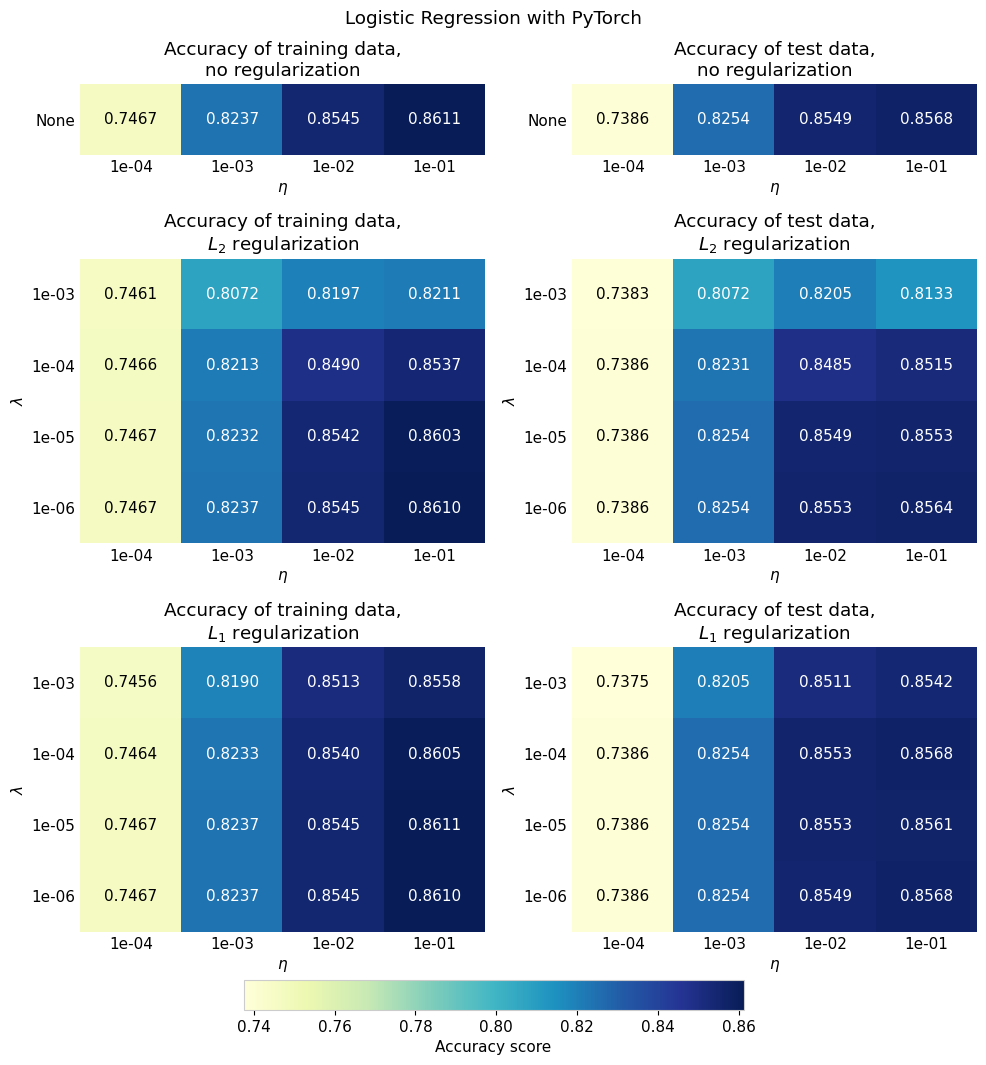

In [18]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 10), height_ratios=[0.25, 1, 1])
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])


# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices  (transpose regularized matrices as they are shape (netas, nlambdas))
matrices = [acc_train_matrix_no_reg[np.newaxis,:], acc_test_matrix_no_reg[np.newaxis,:], acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect="auto", origin="lower", cmap="YlGnBu", vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(color="none", length=0)

    # Set x-ticks
    ax.set_xticks(range(len(etas)))
    ax.set_xticklabels([f"{y:.0e}" for y in etas])
    ax.set_xlabel(r"$\eta$")

    # Set y-ticks
    if matrices[i].shape[0] == 1:  # no regularization (single row)
        ax.set_yticks([0])
        ax.set_yticklabels(["None"])
    else:
        ax.set_yticks(range(len(lambdas)))
        ax.set_yticklabels([f"{x:.0e}" for x in lambdas])
        ax.set_ylabel(r"$\lambda$")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")
cbar.ax.spines["outline"].set_edgecolor("0.8")

plt.suptitle("Logistic Regression with PyTorch")
fig.tight_layout()
fig.savefig(f"{figpath}/PyTorchNN_Logistic_Regression1.pdf", dpi=200, bbox_inches="tight")
plt.show()


In [ ]:
# find the optimal model parameters

matrix_list = [acc_test_matrix_no_reg[:,np.newaxis], acc_test_matrix_L2, acc_test_matrix_L1]
reg_types = ["none", "L2", "L1"]

for k in range(3):
    matrix = matrix_list[k]
    reg_type = reg_types[k]
    
    print("Regularization type: " + reg_type)
    
    i, j = np.unravel_index(np.argmax(matrix), matrix.shape) #index of the highest value in the matrix
    value = matrix[i, j] # highest accuracy in the model

    if reg_type == "none":
        best_eta = etas[i] # corresponding eta

        print(fr"Best accuracy = {value:.4f} at learning rate = {best_eta:.0e}.")

    else:
        best_lambda = lambdas[j] # corresponding lambda
        best_eta = etas[i] # corresponding eta
    
        print(fr"Best accuracy = {value:.4f} at λ = {best_lambda:.0e}, learning rate = {best_eta:.0e}.")

Regularization type: none
Best accuracy = 0.8568 at learning rate = 1.0e-01.
Regularization type: L2
Best accuracy = 0.8564 at λ = 1.0e-06, learning rate = 1.0e-01.
Regularization type: L1
Best accuracy = 0.8568 at λ = 1.0e-06, learning rate = 1.0e-01.


In [24]:
# visualize the best model (with the highest accuracy score) based on the test data

# both no regularization and L1 regularization performes equally well, while L2 regularization performs slightly worse, so choose to vizualize the results without regularization
eta = best_eta

np.random.seed(seed)
torch.manual_seed(seed)
        
# Create new network
model = WeatherNN(input_dim, output_dim)

# Train model
model.train_model(train_loader,
            lr=eta,
            epochs=epochs)

# Make predictions
model.eval()

predictions = []
pred_class = []
targets = []

with torch.no_grad():
    for X, y in test_loader:
        predictions_ = model(X)

        pred_class_ = predictions_.argmax(dim=1)

        predictions.append(predictions_.cpu().numpy())
        pred_class.append(pred_class_.cpu().numpy())
        targets.append(y.cpu().numpy())

# concatenate
predictions = np.concatenate(predictions)
pred_class = np.concatenate(pred_class)
targets = np.concatenate(targets)

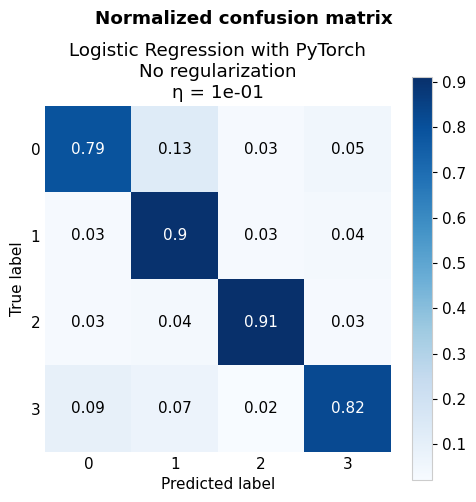

In [ ]:
# plot confusion matrix for the best-performing model (for test data)

fig, ax = plt.subplots(figsize=(5,5))
skplt.metrics.plot_confusion_matrix(targets, pred_class, normalize=True, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(color="none", length=0)
cbar_ax = fig.axes[1]
cbar_ax.spines["outline"].set_edgecolor("0.8")

plt.title(f"Logistic Regression with PyTorch\nNo regularization\nη = {best_eta:.0e}")# \nλ = {best_lmb:.0e}")
plt.suptitle("Normalized confusion matrix", fontweight = "bold")
plt.tight_layout()
fig.savefig(f"{figpath}/PyTorchNN_Logistic_Regression_Confusion_Matrix1.pdf", dpi=200, bbox_inches="tight")
plt.show()

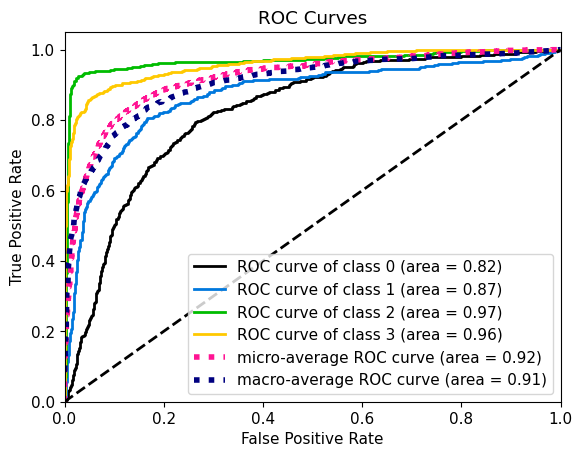

In [27]:
skplt.metrics.plot_roc(targets, predictions)
plt.show()

### **Testing different numbers of epochs and batch sizes**

In [38]:
# set parameters using the best ones found in the previous step
eta = 0.01
lmb = 1e-6

epochs = [20, 50, 100, 200, 500] # different number of epochs

batch_sizes = [16, 32, 64, 128, 256] # different batch sizes

reg_types = [None, "L1", "L2"] # regularization types

**Own NN**

In [39]:
# vary number of epochs and batch sizes for no regularization, and for L1 and L2 regularization

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])

# define network architecture
input_size = X_train.shape[1]
output_size = t_train.shape[1]
layer_sizes = [output_size]
activation_funcs = [softmax]
activation_ders = [derivate(softmax)]


# loop through regularization types, epochs, and batch sizes
for reg_type in reg_types:
    for i in range(len(epochs)):
        epoch = epochs[i]
        for j in range(len(batch_sizes)):
            batch_size = batch_sizes[j]

            # Create a new network
            nn = NeuralNetwork(
                network_input_size = input_size,
                layer_output_sizes = layer_sizes,
                activation_funcs = activation_funcs,
                activation_ders = activation_ders,
                cost_fun = cross_entropy,
                cost_der = cross_entropy_der,
                lamb = lmb,
                cost_fun_type = reg_type
            )

            # Train model using SGD and ADAM optimizer
            nn.train_SGD(
                X_train,
                t_train,
                epochs = epoch,
                learning_rate = eta,
                batch_size = batch_size,
                optimizer = "Adam"
            )

            # evaluate model on training and test data
            if reg_type == "L1":
                acc_train_matrix_L1[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_L1[i, j]  = accuracy(nn, X_test,  t_test)

            elif reg_type == "L2":
                acc_train_matrix_L2[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_L2[i, j]  = accuracy(nn, X_test,  t_test)

            else:
                acc_train_matrix_no_reg[i, j] = accuracy(nn, X_train, t_train)
                acc_test_matrix_no_reg[i, j]  = accuracy(nn, X_test,  t_test)


C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_14036\730939667.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


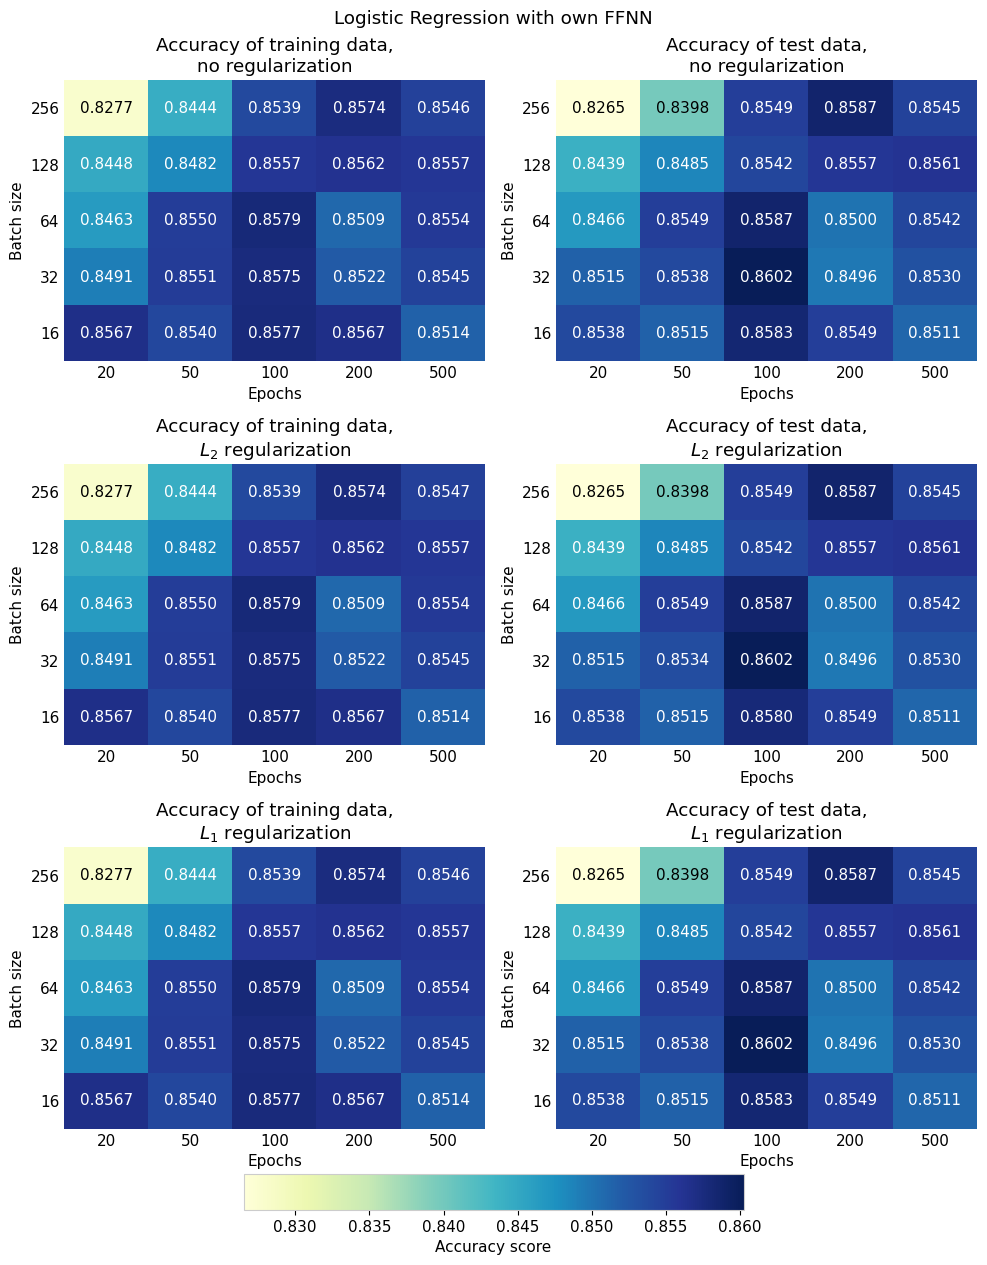

In [ ]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])

# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices
matrices = [acc_train_matrix_no_reg.T, acc_test_matrix_no_reg.T, acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect="auto", origin="lower", cmap="YlGnBu", vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(color="none", length=0)

    # Set x-ticks
    ax.set_xticks(range(len(epochs)))
    ax.set_xticklabels([f"{y}" for y in epochs])
    ax.set_xlabel("Epochs")

    # Set y-ticks
    ax.set_yticks(range(len(batch_sizes)))
    ax.set_yticklabels([f"{x}" for x in batch_sizes])
    ax.set_ylabel("Batch size")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")
cbar.ax.spines["outline"].set_edgecolor("0.8")

plt.suptitle("Logistic Regression with own FFNN")
fig.tight_layout()
fig.savefig(f"{figpath}/FFNN_Logistic_Regression2.pdf", dpi=200, bbox_inches="tight")
plt.show()


In [41]:
# find the optimal model parameters

matrix_list = [acc_test_matrix_no_reg, acc_test_matrix_L2, acc_test_matrix_L1]
reg_types = ["none", "L2", "L1"]

for k in range(3):
    matrix = matrix_list[k]
    reg_type = reg_types[k]
    
    print("Regularization type: " + reg_type)
    
    i, j = np.unravel_index(np.argmax(matrix), matrix.shape) #index of the highest value in the matrix
    value = matrix[i, j] # highest accuracy in the model

    best_epoch = epochs[i] # corresponding number of epochs
    best_batch_size = batch_sizes[j] # corresponding batch size

    print(fr"Best accuracy = {value:.4f} at batch size {best_batch_size} and {best_epoch} epochs.")


Regularization type: none
Best accuracy = 0.8602 at batch size 32 and 100 epochs.
Regularization type: L2
Best accuracy = 0.8602 at batch size 32 and 100 epochs.
Regularization type: L1
Best accuracy = 0.8602 at batch size 32 and 100 epochs.


In [44]:
# visualize the best model (with the highest accuracy score) based on the test data

# all regularization types performed equally well, so choose to vizualize the results without regularization
epoch = best_epoch
M = best_batch_size

# Create a new network
nn = NeuralNetwork(
        network_input_size=input_size,
        layer_output_sizes=layer_sizes,
        activation_funcs=activation_funcs,
        activation_ders=activation_ders,
        cost_fun=cross_entropy,
        cost_der=cross_entropy_der
    )

# Train model using SGD and ADAM optimizer
nn.train_SGD(
        X_train,
        t_train,
        epochs=epoch,
        learning_rate=eta,
        batch_size=batch_size,
        optimizer="Adam"
    )

# Make predictions
predictions = nn._feed_forward(X_test)
pred_class = np.argmax(predictions, axis=1)

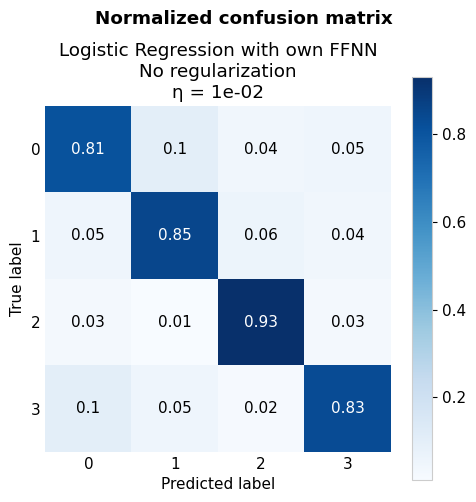

In [45]:
# plot confusion matrix for the best-performing model (for test data)

# convert back from one-hot predictions
t_test_labels = np.argmax(t_test, axis=1)

fig, ax = plt.subplots(figsize=(5,5))
skplt.metrics.plot_confusion_matrix(t_test_labels, pred_class, normalize=True, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(color="none", length=0)
cbar_ax = fig.axes[1]
cbar_ax.spines["outline"].set_edgecolor("0.8")

plt.title(f"Logistic Regression with own FFNN\nNo regularization\nη = {best_eta:.0e}")# \nλ = {best_lmb:.0e}")
plt.suptitle("Normalized confusion matrix", fontweight = "bold")
plt.tight_layout()
fig.savefig(f"{figpath}/FFNN_Logistic_Regression_Confusion_Matrix2.pdf", dpi=200, bbox_inches="tight")
plt.show()

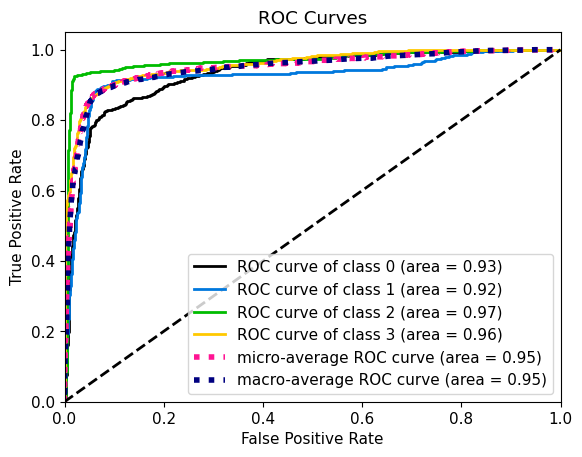

In [46]:
skplt.metrics.plot_roc(t_test_labels, predictions)
plt.show()

**Pytorch**

In [47]:
# set parameters using the best ones found in the previous step
eta = 0.1
lmb = 1e-6

In [48]:
# vary number of epochs and batch sizes for no regularization, and for L1 and L2 regularization

# matrices for storing accuracy results
acc_train_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_no_reg = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L1 = np.zeros([len(epochs),len(batch_sizes)])
acc_train_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])
acc_test_matrix_L2 = np.zeros([len(epochs),len(batch_sizes)])


# loop through regularization types, epochs, and batch sizes
for reg_type in reg_types:
    for i in range(len(epochs)):
        epoch = epochs[i]
        for j in range(len(batch_sizes)):
            batch_size = batch_sizes[j]

            np.random.seed(seed)
            torch.manual_seed(seed)

            # create loaders
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


            # Define network dimensions
            sample, label = next(iter(train_loader))
            input_dim = sample.shape[1]
            output_dim = len(torch.unique(label))
        
        
            # Create new network
            model = WeatherNN(input_dim, output_dim)

            # Train model
            model.train_model(train_loader,
                    lr=eta,
                    epochs=epoch,
                    lmb = lmb,
                    reg_type = reg_type)

            # evaluate model on training and test data
            if reg_type == "L1":
                acc_train_matrix_L1[i, j] = model.evaluate(train_loader)
                acc_test_matrix_L1[i, j]  = model.evaluate(test_loader)

            elif reg_type == "L2":
                acc_train_matrix_L2[i, j] = model.evaluate(train_loader)
                acc_test_matrix_L2[i, j]  = model.evaluate(test_loader)

            else:
                acc_train_matrix_no_reg[i, j] = model.evaluate(train_loader)
                acc_test_matrix_no_reg[i, j]  = model.evaluate(test_loader)



C:\Users\Martine Pedersen\AppData\Local\Temp\ipykernel_14036\3286454280.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


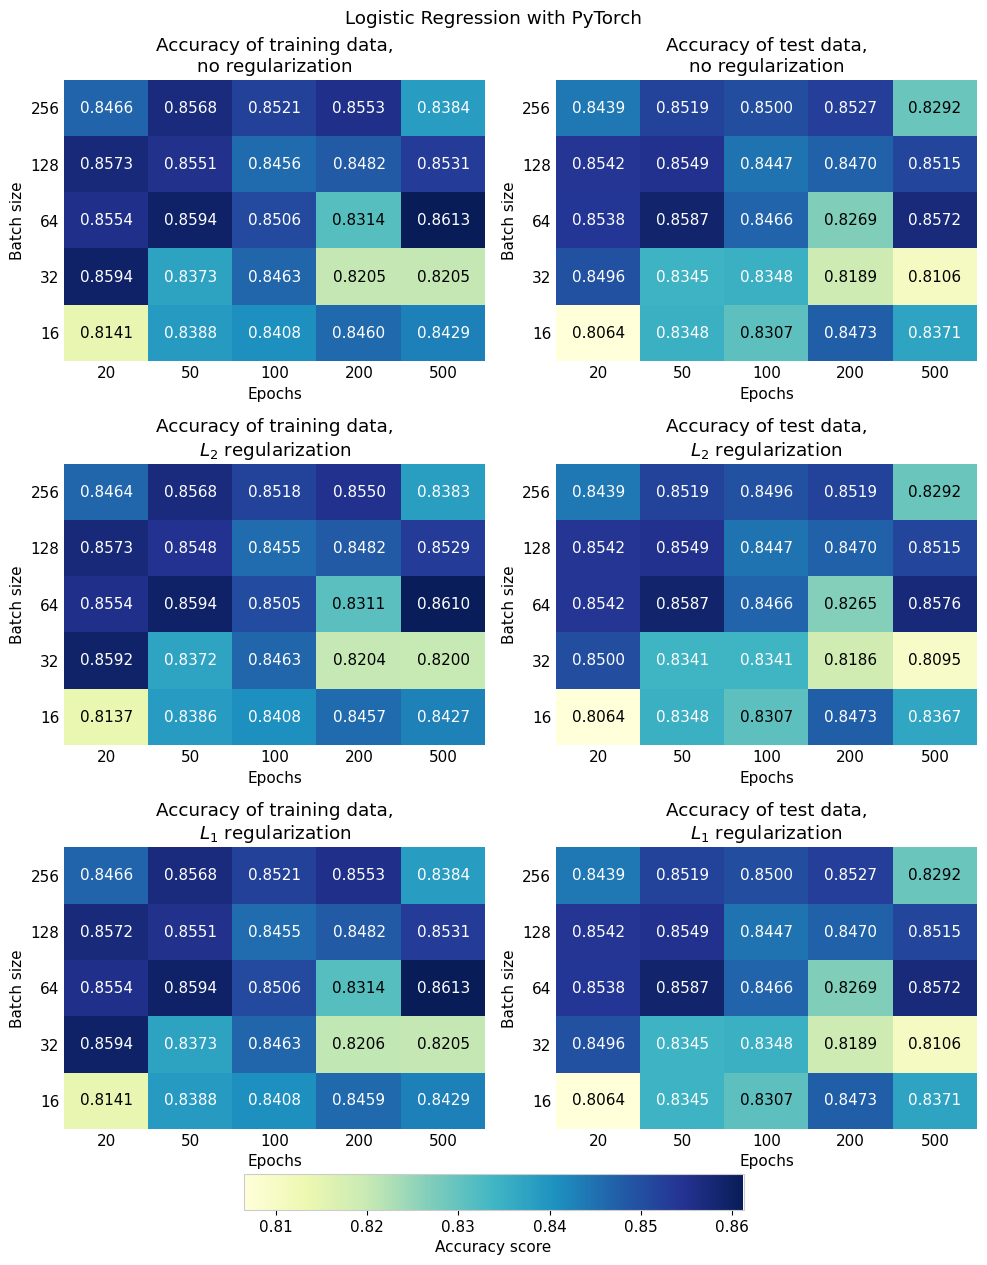

In [49]:
# plot results

plt.rcParams.update({"font.size": 11})

fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()  

# Combine all accuracy values into one array
all_acc_values = np.concatenate([
    acc_train_matrix_no_reg.flatten(),
    acc_test_matrix_no_reg.flatten(),
    acc_train_matrix_L2.flatten(),
    acc_test_matrix_L2.flatten(),
    acc_train_matrix_L1.flatten(),
    acc_test_matrix_L1.flatten()
])

# Set colorbar limits
vmin = np.min(all_acc_values) # min value
vmax = np.max(all_acc_values) # max value
mid = (vmin + vmax)/2

# Titles for each subplot
titles = ["Accuracy of training data,\nno regularization", "Accuracy of test data,\nno regularization", 
          "Accuracy of training data,\n"+r"$L_2$ regularization", "Accuracy of test data,\n"+r"$L_2$ regularization",
          "Accuracy of training data,\n"+r"$L_1$ regularization", "Accuracy of test data,\n"+r"$L_1$ regularization"]

# Corresponding matrices
matrices = [acc_train_matrix_no_reg.T, acc_test_matrix_no_reg.T, acc_train_matrix_L2.T, acc_test_matrix_L2.T, acc_train_matrix_L1.T, acc_test_matrix_L1.T]

# Plot all heatmaps
for i, ax in enumerate(axes):
    im = ax.imshow(matrices[i], aspect="auto", origin="lower", cmap="YlGnBu", vmin=vmin, vmax=vmax)
    ax.set_title(titles[i])

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.tick_params(color="none", length=0)

    # Set x-ticks
    ax.set_xticks(range(len(epochs)))
    ax.set_xticklabels([f"{y}" for y in epochs])
    ax.set_xlabel("Epochs")

    # Set y-ticks
    ax.set_yticks(range(len(batch_sizes)))
    ax.set_yticklabels([f"{x}" for x in batch_sizes])
    ax.set_ylabel("Batch size")

    # Add text annotations
    for r in range(matrices[i].shape[0]):
        for c in range(matrices[i].shape[1]):
            value = matrices[i][r, c]
            color = "white" if value > mid else "black"
            ax.text(c, r, f"{matrices[i][r, c]:.4f}", ha="center", va="center", color=color, fontsize=11)

# Shared colorbar
cbar = fig.colorbar(im, ax=ax, orientation="horizontal", cax=fig.add_axes([0.25, -0.02, 0.5, 0.03]))
cbar.set_label("Accuracy score")
cbar.ax.spines["outline"].set_edgecolor("0.8")

plt.suptitle("Logistic Regression with PyTorch")
fig.tight_layout()
fig.savefig(f"{figpath}/PyTorchNN_Logistic_Regression2.pdf", dpi=200, bbox_inches="tight")
plt.show()


In [50]:
# find the optimal model parameters

matrix_list = [acc_test_matrix_no_reg, acc_test_matrix_L2, acc_test_matrix_L1]
reg_types = ["none", "L2", "L1"]

for k in range(3):
    matrix = matrix_list[k]
    reg_type = reg_types[k]
    
    print("Regularization type: " + reg_type)
    
    i, j = np.unravel_index(np.argmax(matrix), matrix.shape) #index of the highest value in the matrix
    value = matrix[i, j] # highest accuracy in the model

    best_epoch = epochs[i] # corresponding number of epochs
    best_batch_size = batch_sizes[j] # corresponding batch size

    print(fr"Best accuracy = {value:.4f} at batch size {best_batch_size} and {best_epoch} epochs.")


Regularization type: none
Best accuracy = 0.8587 at batch size 64 and 50 epochs.
Regularization type: L2
Best accuracy = 0.8587 at batch size 64 and 50 epochs.
Regularization type: L1
Best accuracy = 0.8587 at batch size 64 and 50 epochs.


In [51]:
# visualize the best model (with the highest accuracy score) based on the test data

# all regularization types performed equally well, so choose to vizualize the results without regularization
epoch = best_epoch
M = best_batch_size

np.random.seed(seed)
torch.manual_seed(seed)

# create loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

# Define network dimensions
sample, label = next(iter(train_loader))
input_dim = sample.shape[1]
output_dim = len(torch.unique(label))
        
# Create new network
model = WeatherNN(input_dim, output_dim)

# Train model
model.train_model(train_loader,
            lr=eta,
            epochs=epoch)


# Make predictions
model.eval()

predictions = []
pred_class = []
targets = []

with torch.no_grad():
    for X, y in test_loader:
        predictions_ = model(X)

        pred_class_ = predictions_.argmax(dim=1)

        predictions.append(predictions_.cpu().numpy())
        pred_class.append(pred_class_.cpu().numpy())
        targets.append(y.cpu().numpy())

# concatenate
predictions = np.concatenate(predictions)
pred_class = np.concatenate(pred_class)
targets = np.concatenate(targets)

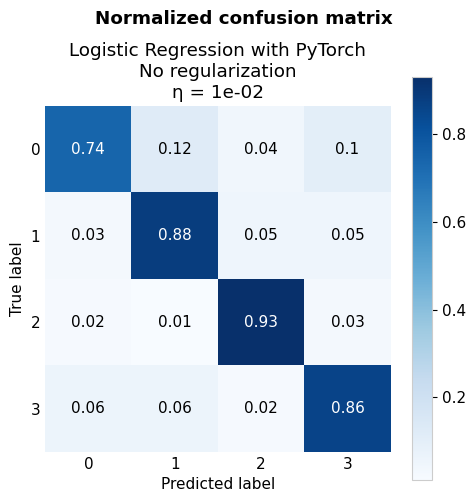

In [52]:
# plot confusion matrix for the best-performing model (for test data)

fig, ax = plt.subplots(figsize=(5,5))
skplt.metrics.plot_confusion_matrix(targets, pred_class, normalize=True, ax=ax)

for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(color="none", length=0)
cbar_ax = fig.axes[1]
cbar_ax.spines["outline"].set_edgecolor("0.8")

plt.title(f"Logistic Regression with PyTorch\nNo regularization\nη = {best_eta:.0e}")# \nλ = {best_lmb:.0e}")
plt.suptitle("Normalized confusion matrix", fontweight = "bold")
plt.tight_layout()
fig.savefig(f"{figpath}/PyTorchNN_Logistic_Regression_Confusion_Matrix2.pdf", dpi=200, bbox_inches="tight")
plt.show()

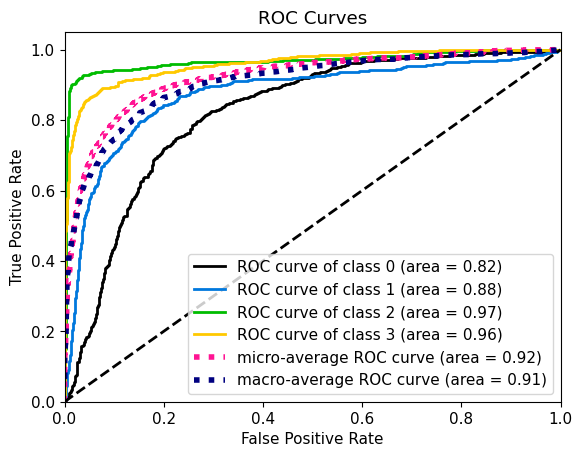

In [53]:
skplt.metrics.plot_roc(targets, predictions)
plt.show()